# Used Vehicles Price Prediction
In this notebook, we will go through the implementation of the steps in the Machine Learning Pipeline for research stage. The aim of the project is to build a machine learning model to predict the sale price of vehicles based on different variables describing aspects of vehicles.

The ML pipeline are as follows:
1. Splitting the preprocessed dataset
2. Training models
3. Making predictions on the best model
4. Feature importance

## 1. Splitting the preprocessed dataset

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [35]:
df_preprocessed = pd.read_csv("../data/vehicles_data_preprocessed.csv")

In [36]:
df_preprocessed.head(5).T

,0,1,2,3,4
region,17,17,17,17,17
price,33590,22590,39590,30990,15000
year,2014,2010,2020,2017,2013
manufacturer,14,8,8,39,13
model,19268,19553,19596,22170,11086
condition,3,3,3,3,1
cylinders,7,7,7,7,6
fuel,3,3,3,3,3
odometer,57923.0,71229.0,19160.0,41124.0,128000.0
title_status,1,1,1,1,1


In [37]:
# Split dataset into train and test set
X = df_preprocessed.drop("price", axis=1)
y = df_preprocessed["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((332553, 31), (36951, 31))

## 2. Training models

In [38]:
# Make function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Test MAE": mean_absolute_error(y_test, test_preds),
              "Training RMSE": root_mean_squared_error(y_train, train_preds),
              "Test RMSE": root_mean_squared_error(y_test, test_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Test R^2": r2_score(y_test, test_preds)}
    return scores

In [40]:
# Start training all of the selected models
seed = 42

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=seed),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=seed),
    "Random Forest Regressor": RandomForestRegressor(n_jobs=-1, random_state=seed)
}

models_r2 = {}

# Iterate over the models dictionary and print the keys
for model_name, model_fn in models.items():
    model = model_fn
    model.fit(X_train, y_train)

    scores = show_scores(model)
    models_r2[model_name] = scores["Test R^2"]

    print(f"Model performance for {model_name}:")
    for metrics, score in scores.items():
        print(f"- {metrics}: {score}")

    print("\n========================================\n")

Model performance for Linear Regression:
- Training MAE: 7005.572541868856
- Test MAE: 6986.573090533084
- Training RMSE: 9393.716814550615
- Test RMSE: 9391.736519538683
- Training R^2: 0.3811171394042068
- Test R^2: 0.37807775793818554


Model performance for Decision Tree:
- Training MAE: 1.5967641677739017
- Test MAE: 2567.178491335372
- Training RMSE: 96.44962588364713
- Test RMSE: 6022.35152705319
- Training R^2: 0.9999347568947852
- Test R^2: 0.744273053879388


Model performance for Gradient Boosting Regressor:
- Training MAE: 5649.795870713572
- Test MAE: 5653.054889635028
- Training RMSE: 7957.095498289122
- Test RMSE: 7964.297676492033
- Training R^2: 0.5559389630143587
- Test R^2: 0.5527614233606046


Model performance for Random Forest Regressor:
- Training MAE: 804.9563262846625
- Test MAE: 2118.051183479138
- Training RMSE: 1600.1047379257777
- Test RMSE: 4201.927899007857
- Training R^2: 0.9820431419138259
- Test R^2: 0.8755079894833859




In [41]:
# Put model with their corresponding R2 score into a dataframe
r2_df = pd.DataFrame(list(models_r2.items()), columns=["model_name", "r2_score"]).sort_values(by="r2_score", ascending=False)
r2_df

,model_name,r2_score
3,Random Forest Regressor,0.875508
1,Decision Tree,0.744273
2,Gradient Boosting Regressor,0.552761
0,Linear Regression,0.378078


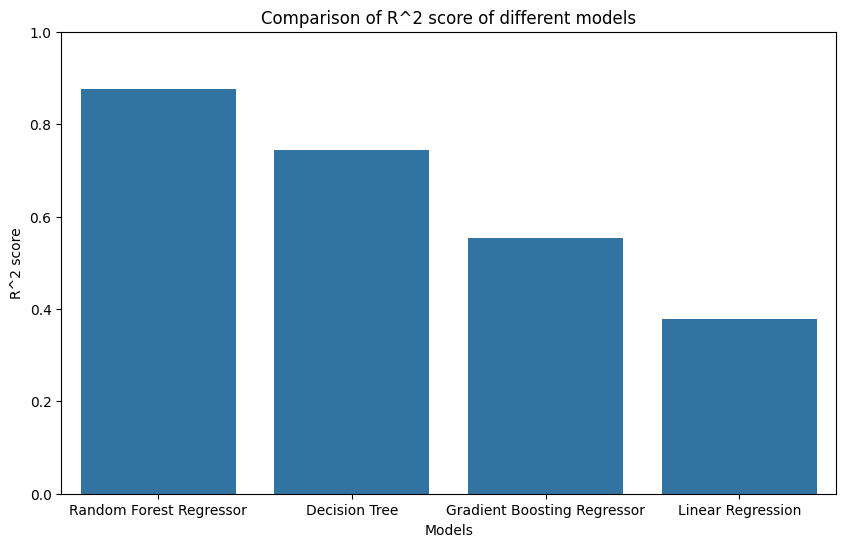

In [42]:
# Plot R^2 results
plt.figure(figsize=(10,6))
sns.barplot(data=r2_df, x="model_name", y="r2_score")
plt.title("Comparison of R^2 score of different models")
plt.xlabel("Models")
plt.ylabel("R^2 score")
plt.ylim(top=1.0)
plt.show()

## 3. Making predictions using the best model on test dataset

In [43]:
# Fit to new model with tuned hyperparameters on full dataset
rf_model = RandomForestRegressor(n_jobs=-1, 
                                 random_state=42)

rf_model.fit(X_train, y_train)
y_preds = rf_model.predict(X_test)

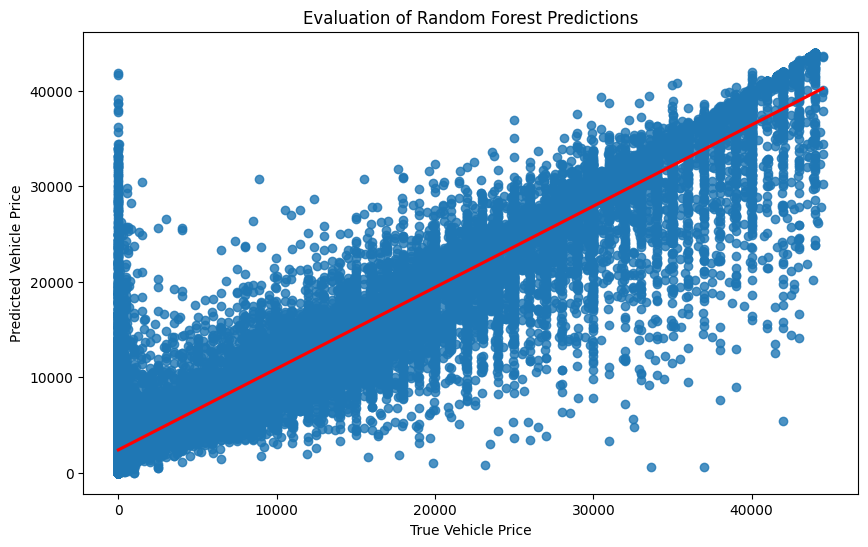

In [44]:
# Plot y_preds and y_test
plt.figure(figsize=(10,6))
sns.regplot(x=y_test, y=y_preds, line_kws=dict(color="r"))
plt.xlabel("True Vehicle Price")
plt.ylabel("Predicted Vehicle Price")
plt.title("Evaluation of Random Forest Predictions")
plt.show()

## 4. Feature importance

In [45]:
rf_model.feature_importances_

array([0.01923913, 0.25975168, 0.03829763, 0.07130989, 0.0311815 ,
       0.05821028, 0.03775767, 0.09384229, 0.00373865, 0.0751357 ,
       0.03797902, 0.02448337, 0.02033956, 0.01508165, 0.06580227,
       0.08742898, 0.        , 0.00175991, 0.01942608, 0.00433901,
       0.00452564, 0.00162699, 0.00036398, 0.00638501, 0.00407353,
       0.00085231, 0.00070992, 0.00030458, 0.00580684, 0.00266892,
       0.00757802])

In [46]:
# Make a function to plot feature importance
def plot_features(columns, importances, n=None):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))

    # Plot the dataframe
    num_shown = len(columns) if n == None else n

    plt.figure(figsize=(10,6))
    sns.barplot(x=df["feature_importances"][:num_shown], y=df["features"][:num_shown])
    plt.title("Feature importance based on RF model")
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.show()

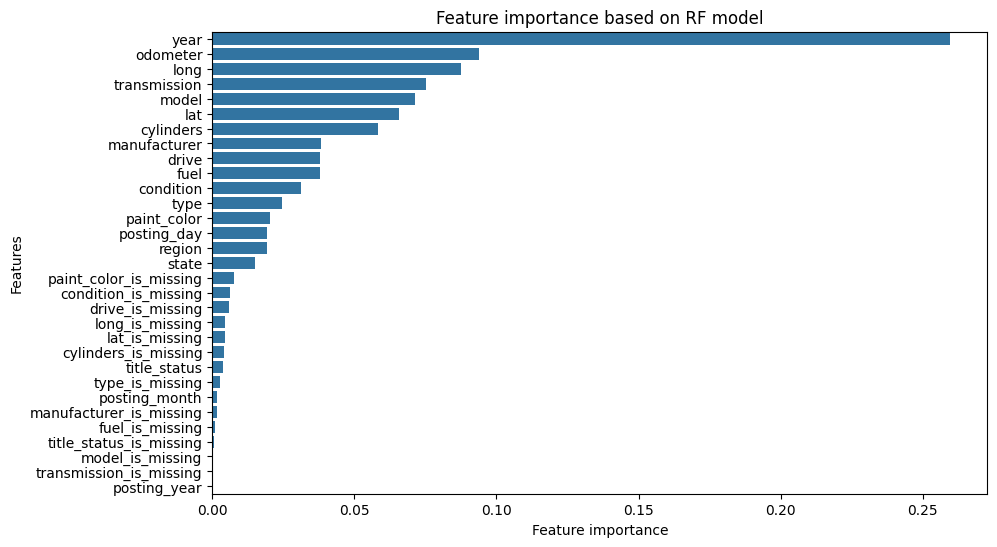

In [47]:
# Plot feature importance
plot_features(X_train.columns, rf_model.feature_importances_)

**Conclusions:**
1. Random forest regression achieve the highest R2 Score of 0.87 on test dataset.
2. Feature importance shown that "year" feature is the most significant feature compared with others.